_________________________________________________________________________________________________________________

# Feature Based Image Alignment 

We will demonstrate the steps by way of an example in which we will align a photo of a form taken using a mobile phone to a template of the form. The technique we will use is often called “feature based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation is then calculated based on these matched features that warps one image on to the other.

In many applications, we have two images of the same scene or the same document, but they are not aligned. In other words, if you pick a feature (say a corner) on one image, the coordinates of the same corner in the other image is very different.

Image alignment (also known as image registration) is the technique of warping one image ( or sometimes both images ) so that the features in the two images line up perfectly.

At the heart of image alignment techniques is a simple 3×3 matrix called __Homography__. 


<img src="./Images/homography-example.jpg" style="width: 800px;"> 

Consider two images of a plane (top of the book) shown in Figure above. The red dot represents the same physical point in the two images. In computer vision jargon we call these corresponding points. Figure shows four corresponding points in four different colors — red, green, yellow and orange. 

_A Homography is a transformation ( a 3×3 matrix ) that maps the points in one image to the corresponding points in the other image._

If we know 4 or more corresponding points in the two images, we can use the OpenCV function _**findHomography**_ to find the homography. An example of four corresponding points is shown in the Figure above. The red, green, yellow and orange points are corresponding points.

Internally the function findHomography solves a linear system of equations to find the homography. Documentation can be seen here (https://kite.com/python/docs/cv2.findHomography)


### How to find corresponding points automatically ?
In many Computer Vision applications, we often need to identify interesting stable points in an image. These points are called keypoints or feature points. There are several keypoint detectors implemented in OpenCV ( e.g. SIFT, SURF, and ORB).

In this tutorial, we will use the ORB feature detector because SIFT and SURF are patented and if you want to use it in a real-world application, you need to pay a licensing fee. ORB is fast, accurate and license-free! 

ORB stands for Oriented FAST and Rotated BRIEF. 

ORB keypoints are shown in the image below using circles. Documentation about ORB feature detector can be seen here.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html#orb-in-opencv

### Feature matching

The homography that relates the two images can be calculated only if we know corresponding features in the two images. So a matching algorithm is used to find which features in one image match features in the other image. For this purpose, the descriptor of every feature in one image is compared to the descriptor of every feature in the second image to find good matches.

_cv2.DescriptorMatcher_create_ method is used for feature matching. Behind the scene it uses hamming distance measure to compute the similarity match between feature descriptors of local keypoints.


***

### Steps for Feature Based Image Alignment
Now we are in a position to summarize the steps involved in image alignment. The description below refers to the code in the next sections.

#### 1: Read Images : 
We first read the reference image (or the template image) and the image we want to align to this template

#### 2: Detect Features: 
We then detect ORB features in the two images. Although we need only 4 features to compute the homography, typically hundreds of features are detected in the two images. We control the number of features using the parameter **MAX_FEATURES** in the code.We detect features and compute the descriptors using **_detectAndCompute_** method.

#### 3: Match Features: 
We find the matching features in the two images, sort them by goodness of match and keep only a small percentage of original matches. We finally display the good matches on the images and write the file to disk for visual inspection. We use the hamming distance as a measure of similarity between two feature descriptors. The matched features are shown in the figure below by drawing a line connecting them. Notice, we have many incorrect matches and thefore we will need to use a robust method to calculate homography in the next step.

Matching keypoints are shown by drawing a line between them. The matches are not perfect and therefore we need a robust method for calculating the homography in the next step.

<img src="./Images/keypoint-matching.jpg" style="width: 600px;"> 

#### 4: Calculate Homography: 
A homography can be computed when we have 4 or more corresponding points in two images. Automatic feature matching explained in the previous section does not always produce 100% accurate matches. It is not uncommon for 20-30% of the matches to be incorrect. Fortunately, the **_findHomography_** method utilizes a robust estimation technique called Random Sample Consensus (RANSAC) which produces the right result even in the presence of large number of bad matches.

#### 5: Warping image: 
Once an accurate homography has been calculated, the transformation can be applied to all pixels in one image to map it to the other image. This is done using the **_warpPerspective_** function in OpenCV. 

**Below is the function _def alignImages(im1, im2):_ which implemented the above mentioned five steps**

In [3]:
import numpy as np
import gzip
import struct
import cv2
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
MAX_MATCHES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_MATCHES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
  
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
  
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)
  
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
  
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
  
  return im1Reg, h

**The main function to call the above mentioned _def alignImages(im1, im2):_.**

In [5]:
# Read reference image
refFilename = "./Images/form.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = "./Images/scanned-form.jpg"
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Write aligned image to disk. 
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename); 
cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

Reading reference image :  ./Images/form.jpg
Reading image to align :  ./Images/scanned-form.jpg
Aligning images ...
Saving aligned image :  aligned.jpg
Estimated homography : 
 [[ 1.40104964e+00 -2.02959669e-01 -7.41342584e+00]
 [ 2.25280216e-01  1.52880342e+00 -4.85162159e+02]
 [-6.39599712e-05  1.34896590e-04  1.00000000e+00]]


***
***

# Digit classification using HOG features

### This example shows how to classify digits using HOG features and a Random Forest classifier.

Object classification is an important task in many computer vision applications, including surveillance, automotive safety, and image retrieval. For example, in an automotive safety application, you may need to classify nearby objects as pedestrians or vehicles. Regardless of the type of object being classified, the basic procedure for creating an object classifier is:

- Acquire a labeled data set with images of the desired object.

- Partition the data set into a training set and a test set.

- Train the classifier using features extracted from the training set.

- Test the classifier using features extracted from the test set.

The information about MNIST dataset can be see here (https://en.wikipedia.org/wiki/MNIST_database) and here (http://yann.lecun.com/exdb/mnist/)

Below are the Helper functions to Load MNIST digit classification dataset. 

In [6]:


def read_data(label, image):
    with gzip.open(label, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.frombuffer (flbl.read(), dtype=np.int8)
    with gzip.open(image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.frombuffer (fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

(train_lbl, train_img) = read_data(r'./Dataset/train-labels-idx1-ubyte.gz', 
                                   r'./Dataset/train-images-idx3-ubyte.gz')
(test_lbl, test_img) = read_data(r'./Dataset/t10k-labels-idx1-ubyte.gz', 
                                   r'./Dataset/t10k-images-idx3-ubyte.gz')

print("Training Samples : " +  str(len(train_img)))
print("Test Samples : " +  str(len(test_img)))
train_img[0].shape

print(train_lbl)
print(test_lbl)



Training Samples : 60000
Test Samples : 10000
[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


__________________________________________________________________________________________________
### Visualize dataset
__Print some of the training and test images along with their respective labels for verification__

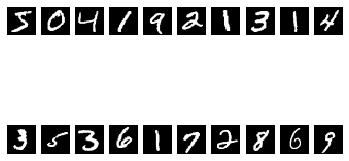

Training label: [5 0 4 1 9 2 1 3 1 4]
Training label: [3 5 3 6 1 7 2 8 6 9]


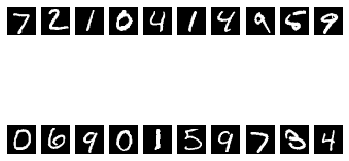

Test label: [7 2 1 0 4 1 4 9 5 9]
Testlabel: [0 6 9 0 1 5 9 7 3 4]


In [7]:

for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('Training label: %s' % (train_lbl[0:10],))
print('Training label: %s' % (train_lbl[10:20],))

for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(test_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('Test label: %s' % (test_lbl[0:10],))
print('Testlabel: %s' % (test_lbl[10:20],))

### Computing HoG features
* __Load the 'train_img_count' training images__
* __Loop through the images to Compute HOG features for each of the digit image__
* __Get the respective labels__

Pythong library _skimage_ is used to compute the HOG features. Have a look at the documentation of function _features.hog_ here (https://kite.com/python/docs/skimage.feature.hog)

A number of feature detectors implementation is availabe in this pakage. The documentation can be seen here (https://scikit-image.org/docs/dev/api/skimage.feature.html)

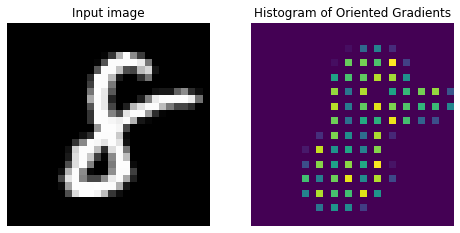

In [8]:
from skimage import feature
from skimage import exposure
import matplotlib.pyplot as plt
import cv2


train_data = []
train_img_count = 5000

# loop over the images
for i in range(train_img_count):
	# pre-process image here if needed
    # Computing the HOG features. Keep and eye on the parameters used in this function call.
    (H1, hogImage1)=  feature.hog(train_img[i], orientations = 3, pixels_per_cell  = (2, 2), cells_per_block  = (2, 2), transform_sqrt=True, block_norm  = 'L1' , visualize=True)
    train_data.append(H1)


train_labels = train_lbl[0:train_img_count]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_img[i], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hogImage1, in_range=(0, 255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



In [9]:
# length of computed feature vector
len(H1)

2028

### Training of Random forest classifier

Python library _sklearn_ has builtin implementations of many classifiers, e.g. multiclass SVM, Random Forest e.t.c. Any of the classifier can be used. 

In this example we have used Random Forest Classifier.
Documentation can be seen here (https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [10]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 50) # train RTC model
model.fit(train_data, train_labels)
print("training completed")

training completed


### Prediction of digits using test images. 

__Compute HOG features and use the trainined classifier model to predict the digit.__

In [11]:

test_data = []
test_img_count = 10000
# loop over the images
for i in range(test_img_count):
	# pre-process image here if needed
    (H1, hogImage1)=  feature.hog(test_img[i], orientations = 3, pixels_per_cell  = (2, 2), cells_per_block  = (2, 2), transform_sqrt=True, block_norm  = 'L1' , visualize=True)
    test_data.append(H1)


test_labels = test_lbl[0:test_img_count]


# Create predictions
predicted_labels = model.predict(test_data)
print("Prediction completed")
# uncomment below lines to get the pridicted labesl and the actural labels printed.
#print(predicted_labels)
#print(test_labels)

### Computing performance measures

_ConfusionMatrix_ from __pandas_ml__ python library/package is used to evaluate the performance of digit classification task. Documentation can be seen here (https://pandas-ml.readthedocs.io/en/latest/conf_mat.html)

In [12]:
mask = predicted_labels==test_labels
correct = np.count_nonzero(mask)
print (correct*100.0/predicted_labels.size)
reasult = predicted_labels.astype(int)

85.7


In [13]:

from pandas_ml import ConfusionMatrix

confusion_matrix = ConfusionMatrix(test_labels, predicted_labels)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted   0    1    2    3    4   5   6   7   8    9  __all__
Actual                                                         
0          81    0    0    0    0   1   0   0   2    1       85
1           0  125    0    0    0   0   1   0   0    0      126
2           2    2   94    5    1   0   0   4   8    0      116
3           0    1    8   84    2   6   0   1   2    3      107
4           0    1    1    0  101   0   1   1   0    5      110
5           3    2    0    8    0  62   2   2   1    7       87
6           8    2    1    1    1   2  72   0   0    0       87
7           0    3    3    0    0   0   0  88   0    5       99
8           3    2    8    2    1   0   3   2  61    7       89
9           0    0    0    3    0   0   0   1   1   89       94
__all__    97  138  115  103  106  71  79  99  75  117     1000


In [14]:
confusion_matrix.print_stats()

c:\python\notebooks\classexercise_1\env\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted   0    1    2    3    4   5   6   7   8    9  __all__
Actual                                                         
0          81    0    0    0    0   1   0   0   2    1       85
1           0  125    0    0    0   0   1   0   0    0      126
2           2    2   94    5    1   0   0   4   8    0      116
3           0    1    8   84    2   6   0   1   2    3      107
4           0    1    1    0  101   0   1   1   0    5      110
5           3    2    0    8    0  62   2   2   1    7       87
6           8    2    1    1    1   2  72   0   0    0       87
7           0    3    3    0    0   0   0  88   0    5       99
8           3    2    8    2    1   0   3   2  61    7       89
9           0    0    0    3    0   0   0   1   1   89       94
__all__    97  138  115  103  106  71  79  99  75  117     1000


Overall Statistics:

Accuracy: 0.857
95% CI: (0.8337528434032756, 0.8781213571241073)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.8

In [15]:
confusion_matrix.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.835052,0.952941,0.89011,85
1,0.905797,0.992063,0.94697,126
2,0.817391,0.810345,0.813853,116
3,0.815534,0.785047,0.8,107
4,0.95283,0.918182,0.935185,110
5,0.873239,0.712644,0.78481,87
6,0.911392,0.827586,0.86747,87
7,0.888889,0.888889,0.888889,99
8,0.813333,0.685393,0.743902,89


In [16]:
confusion_matrix.pred

Predicted
0     97
1    138
2    115
3    103
4    106
5     71
6     79
7     99
8     75
9    117
Name: Predicted, dtype: int64

In [17]:
confusion_matrix.stats_class

Classes,0,1,2,3,4,5,6,7,8,9
Population,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
P: Condition positive,85,126,116,107,110,87,87,99,89,94
N: Condition negative,915,874,884,893,890,913,913,901,911,906
Test outcome positive,97,138,115,103,106,71,79,99,75,117
Test outcome negative,903,862,885,897,894,929,921,901,925,883
TP: True Positive,81,125,94,84,101,62,72,88,61,89
TN: True Negative,899,861,863,874,885,904,906,890,897,878
FP: False Positive,16,13,21,19,5,9,7,11,14,28
FN: False Negative,4,1,22,23,9,25,15,11,28,5
"TPR: (Sensitivity, hit rate, recall)",0.952941,0.992063,0.810345,0.785047,0.918182,0.712644,0.827586,0.888889,0.685393,0.946809


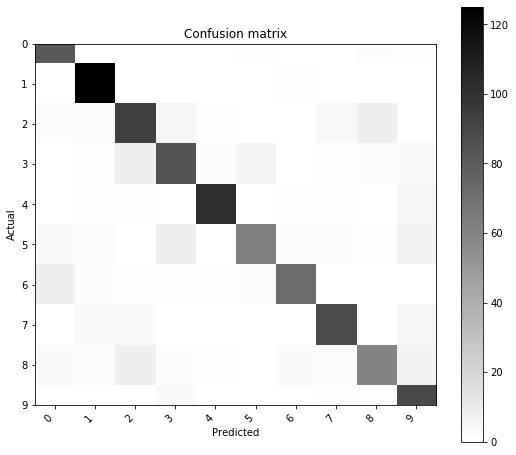

In [18]:
confusion_matrix.plot()
plt.show()